<a href="https://colab.research.google.com/github/chrismoroney/TensorFlow-practice/blob/main/predicting_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())


x =  [[3 4 5 6]
 [4 5 6 7]]
y =  [[7]
 [8]]
x =  [[5 6 7 8]
 [1 2 3 4]]
y =  [[9]
 [5]]
x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]


<h1> Windowed Version of Time Series Dataset </h1>

In [12]:
def trend(time, slope = 0):
  return slope*time

In [13]:
def season_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

In [14]:
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * season_pattern(season_time)

In [15]:
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [17]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level=5

series = baseline + trend(time, slope)
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [19]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [21]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[34.756157 36.903816 35.554333 35.147533 42.41752  40.029854 34.855625
  42.89368  40.00781  42.611366 41.771065 34.55392  35.974087 42.587666
  41.97937  38.899445 39.66713  45.545475 36.276054 42.04627 ]], shape=(1, 20), dtype=float32)
tf.Tensor([38.376797], shape=(1,), dtype=float32)


In [22]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss = "mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [25]:
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
46/46 [==============================] - 2s 7ms/step - loss: 913.7144
Epoch 2/100
46/46 [==============================] - 1s 6ms/step - loss: 47.9665
Epoch 3/100
46/46 [==============================] - 1s 7ms/step - loss: 45.2924
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 43.7451
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 40.9655
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 51.2470
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 43.9757
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 40.2107
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 38.9978
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 51.8009
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 40.4998
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 38.5893
Epoch 13/100
46/46 [====

In [27]:
print(series[1000:1020])
print(series[1020])

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606


In [28]:
print(model.predict(series[1000:1020][np.newaxis]))

1/1 [==============================] - 0s 370ms/step
[[100.46605]]


In [37]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(
      model.predict(
          series[time:time+window_size][np.newaxis]
      )
  )

1/1 [==============================] - 0s 32ms/step


In [38]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

In [49]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

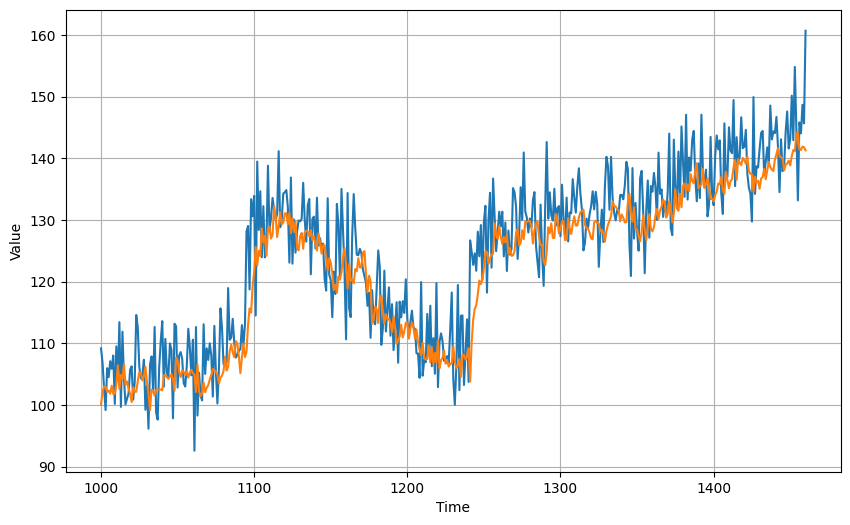

In [50]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.940508

In [53]:
model.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6,  momentum=0.9))

In [54]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 13-8 * 10**(epoch/20))

In [55]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum=0.9)
model.compile(loss="mse", optimizer = optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

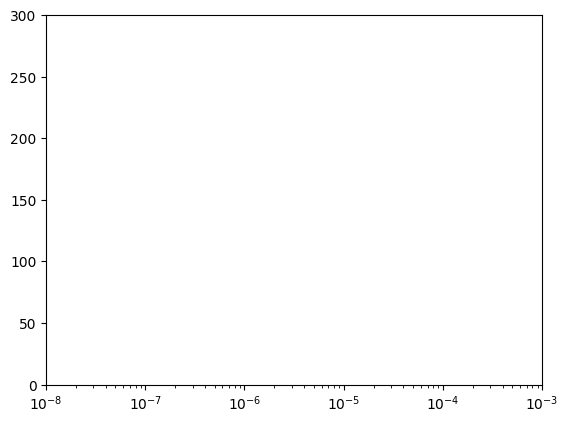

In [57]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])